In [1]:
!pip install torch torchvision diffusers


In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import DDPMPipeline, DDPMScheduler
import numpy as np
import matplotlib.pyplot as plt


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
import kagglehub

# Re-download the dataset
path = kagglehub.dataset_download("thomasqazwsxedc/alphabet-characters-fonts-dataset")
print("Path to dataset files:", path)


100%|██████████| 559M/559M [00:03<00:00, 156MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/thomasqazwsxedc/alphabet-characters-fonts-dataset/versions/2


In [4]:
import os

# Check if the file exists after re-downloading
npz_path = f"/root/.cache/kagglehub/datasets/thomasqazwsxedc/alphabet-characters-fonts-dataset/versions/2/character_fonts (with handwritten data).npz"
if os.path.exists(npz_path):
    print("The .npz file is available.")
else:
    print("The .npz file could not be found.")


The .npz file is available.


In [5]:
import numpy as np

# Load the dataset
data = np.load(npz_path)

# Extract images and labels
images = data['images']
labels = data['labels']

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: (762213, 28, 28)
Labels shape: (762213,)


In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define the preprocessing step
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),  # Resize to 32x32 if needed by the model
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

class AlphabetDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create dataset and dataloader
alphabet_dataset = AlphabetDataset(images, labels, transform=preprocess)
dataloader = DataLoader(alphabet_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)


In [7]:
from diffusers import DDPMPipeline, DDPMScheduler

# Initialize the model
model = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32")

# Set up the scheduler
scheduler = DDPMScheduler.from_config(model.scheduler.config)

# Set the model to training mode
model.unet.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(12

In [8]:
from torch.optim import Adam

# Move the UNet model to the GPU
model.unet.to("cuda")

# Define the optimizer using the UNet model's parameters
optimizer = Adam(model.unet.parameters(), lr=1e-4)


In [9]:
optimizer = Adam(model.unet.parameters(), lr=1e-4)


In [19]:
torch.cuda.empty_cache()


In [20]:
# Main Training Loop

import torch.nn.functional as F
import torch
from torch.optim import Adam
from torch.amp import GradScaler, autocast  # Updated AMP import
from diffusers import DDPMPipeline, DDPMScheduler
import shutil
from google.colab import files

# Initialize scheduler, optimizer, and AMP scaler
scheduler = DDPMScheduler.from_config(model.scheduler.config)
optimizer = Adam(model.unet.parameters(), lr=1e-4)
scaler = GradScaler('cuda')  # Updated AMP syntax

# Set the model to training mode
model.unet.train()

# Define the number of epochs, gradient accumulation steps, and gradient clipping threshold
num_epochs = 5
accumulation_steps = 4  # Number of steps to accumulate gradients
max_grad_norm = 1.0     # Gradient clipping threshold to prevent 'nan' values

# Training Loop with AMP, Gradient Accumulation, and Gradient Clipping
for epoch in range(num_epochs):
    total_loss = 0
    optimizer.zero_grad()  # Ensure gradients are zeroed out at the start

    for i, batch in enumerate(dataloader):
        images, _ = batch  # Ignore labels for now
        images = images.to("cuda")

        # Check and expand channels if images are grayscale
        if images.shape[1] == 1:  # If the batch is 1-channel
            images = images.expand(-1, 3, -1, -1)  # Expand to 3 channels

        # Sample random noise to add to images
        noise = torch.randn_like(images).to("cuda")
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (images.shape[0],), device="cuda").long()

        # Add noise to the images (forward diffusion process)
        noisy_images = scheduler.add_noise(images, noise, timesteps)

        # Forward pass with AMP enabled
        with autocast('cuda'):
            noise_pred = model.unet(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise) / accumulation_steps  # Scale loss for accumulation

        # Check for NaN loss and reset gradients if NaN is detected
        if torch.isnan(loss):
            print("NaN loss detected. Skipping this batch.")
            optimizer.zero_grad()
            continue

        # Backward pass with AMP
        scaler.scale(loss).backward()

        # Gradient accumulation step with gradient clipping
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)  # Unscale gradients before clipping
            torch.nn.utils.clip_grad_norm_(model.unet.parameters(), max_grad_norm)  # Clip gradients

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()  # Reset gradients for the next accumulation

        total_loss += loss.item() * accumulation_steps  # Scale back for reporting

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

# Save the trained model after training is complete
model_save_path = "/content/trained_model"
model.unet.save_pretrained(model_save_path)

# Zip the model directory to prepare it for download
shutil.make_archive(model_save_path, 'zip', model_save_path)

# Download the model zip file
files.download(f"{model_save_path}.zip")


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 4.81 MiB is free. Process 52902 has 39.55 GiB memory in use. Of the allocated memory 38.71 GiB is allocated by PyTorch, and 336.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

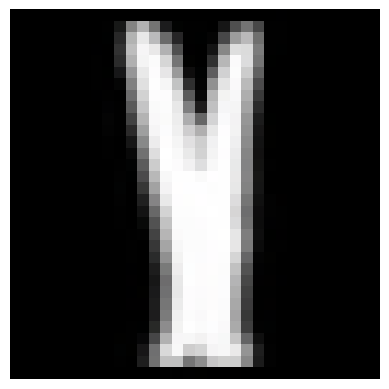

In [14]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.unet.eval()

# Generate an image by starting from random noise
noise = torch.randn((1, 3, 32, 32)).to("cuda")  # Adjust dimensions to match model input shape

with torch.no_grad():
    for t in reversed(range(scheduler.config.num_train_timesteps)):
        noise_pred = model.unet(noise, torch.tensor([t]).to("cuda")).sample
        noise = scheduler.step(noise_pred, t, noise).prev_sample

# Convert and visualize the generated image
generated_image = noise.squeeze().cpu().numpy().transpose(1, 2, 0)
generated_image = (generated_image * 0.5 + 0.5).clip(0, 1)  # Rescale to [0, 1]
plt.imshow(generated_image)
plt.axis("off")
plt.show()


In [4]:
model.unet.save_pretrained("/content/drive/MyDrive/project/final_model")
torch.save(optimizer.state_dict(), "/content/drive/MyDrive/project/final_optimizer_state.pt")
scaler_state = scaler.state_dict()
torch.save(scaler_state, "/content/drive/MyDrive/project/final_scaler_state.pt")


NameError: name 'model' is not defined